<a href="https://colab.research.google.com/github/juliorodrigues07/url_detection/blob/sprint2/notebook/url_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PA 1 - Data Mining**

---



# **1.   Importing Libraries**

In [9]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from warnings import filterwarnings
from urllib.parse import urlparse
from pandas import DataFrame
from pandas import read_csv
from pandas import qcut
from numpy import array
from os.path import isdir
from os import getcwd
from os import chdir
from os import mkdir
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re

filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# **2.   Data Visualization**

In [5]:
def plot_distribution(dataset):

    split = dataset.type.value_counts()

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=split.index, y=split, palette='Reds')

    ax.set_title('Class Distribution')
    ax.set_ylabel("Amount", fontsize=18)
    ax.set_xlabel("URL Types", fontsize=18)

    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.8)
    ax.grid(which='major', alpha=0.8)
    plt.show()


def pie_chart(dataset, names):

    colors = sns.color_palette('pastel')[0:5]
    split = dataset.type.value_counts()
    plt.pie(split, colors=colors, shadow=True, startangle=45, autopct='%.0f%%')

    plt.title('Class Distribution')
    plt.legend(names, loc="best")
    plt.axis('equal')
    plt.show()


def feature_dist(dataset, key):

    # plt.title('Protocol')
    sns.countplot(x=key, data=dataset, palette='Blues')
    plt.ylabel('Instances')
    plt.show()


def url_len_boxplot(dataset):

    fig, axes = plt.subplots(figsize=(18, 10))
    sns.boxplot(ax=axes, x='type', y='url_length', data=dataset)

    axes.set_title('URL lengths between each type')
    axes.set_xlabel('URL Length')
    axes.set_xlabel('Type')
    plt.show()


def plot_feature_importance(cols, feature_dataframe):

    feature_data = DataFrame({'Feature': cols, 'Feature Relevance': feature_dataframe['Mean'].values})
    feature_data = feature_data.sort_values(by='Feature Relevance', ascending=False)

    plt.figure(figsize=(10, 12))
    plt.title('Average Feature Importance (XGBoost)', fontsize=14)

    s = sns.barplot(y='Feature', x='Feature Relevance', data=feature_data, orient='h', palette='coolwarm')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)

    plt.show()


def calculate_importances(perm_importances, features_names):

    features = array(features_names)
    sorted_idx = perm_importances.importances_mean.argsort()

    plt.barh(features[sorted_idx], perm_importances.importances_mean[sorted_idx])
    plt.title('Permutation Feature Importance')
    plt.ylabel('Feature')
    plt.xlabel("Feature Relevance")

    plt.show()

# **3.   Feature Engineering**

In [21]:
def discretize_values(column, key):

    encoding = LabelEncoder()

    # Discretize column values (bening, phishing, malware, ...) => [0, 1, 2, ...]
    encoding.fit(column[key])
    column[key] = encoding.transform(column[key].copy())

    return column


def url_protocol(url):
    
    protocol = urlparse(url).scheme

    # Identifying which communication protocol each site uses
    match = str(protocol)
    if match == 'https':
        return 2
    elif match == 'http':
        return 0
    else:
        return 1


def url_length(dataset):

    # Gets the brute length of each url
    dataset['url_length'] = dataset['url'].apply(lambda x: len(x))
    return dataset


def count_digits(url):

    total = 0

    # Counts the number of digits present in each url
    for c in url:
        if c.isnumeric():
            total += 1

    return total


def count_dirs(url):

    # Counts the number of directories present in each url path
    url_path = urlparse(url).path
    return url_path.count('/')


def first_directory(url):

    url_path = urlparse(url).path

    # Gets the brute length of each url first directory
    try:
        fd_length = len(url_path.split('/')[1])
    except IndexError:
        fd_length = 0

    return fd_length


def odd_words(url):

    # Search for suspicious words related to phishing in each url
    pattern = re.search('free|account|signin|bonus|lucky|extra|payment|details', url)

    if pattern:
        return 1
    else:
        return 0

# 4.   **Machine Learning Models**

In [20]:
def holdout_split(attributes, classes):

    # Training and test sets obtained by stratified and random splitting (80% and 20% - holdout)
    training_attributes, test_attributes, training_classes, test_classes = train_test_split(attributes,
                                                                                            classes,
                                                                                            stratify=classes,
                                                                                            test_size=0.2,
                                                                                            shuffle=True,
                                                                                            random_state=42)
    
    return training_attributes, test_attributes, training_classes, test_classes


def decision_tree(training_attributes, test_attributes, training_classes, test_classes, class_names):

    # Model construction with decision tree
    classifier = DecisionTreeClassifier()
    classifier.fit(training_attributes, training_classes)

    # Extraction of the obtained test results
    predictions = classifier.predict(test_attributes)
    print(classification_report(test_classes, predictions, target_names=class_names))

    return classifier.feature_importances_


def svm_model(training_attributes, test_attributes, training_classes, test_classes, class_names):

    classifier = OneVsRestClassifier(SVC(kernel='rbf', gamma=0.01, C=2), n_jobs=-1)
    classifier.fit(training_attributes, training_classes)

    predictions = classifier.predict(test_attributes)
    print(classification_report(test_classes, predictions, target_names=class_names))

    perm_importance = permutation_importance(classifier, test_attributes, test_classes)
    return perm_importance


def logistic_regression(training_attributes, test_attributes, training_classes, test_classes, class_names):

    classifier = LogisticRegression(n_jobs=-1)
    classifier.fit(training_attributes, training_classes)

    predictions = classifier.predict(test_attributes)
    print(classification_report(test_classes, predictions, target_names=class_names))

    perm_importance = permutation_importance(classifier, test_attributes, test_classes)
    return perm_importance


def xgb_classification(training_attributes, test_attributes, training_classes, test_classes, class_names):

    # TODO: Ensemble method: essential to aplly hiperparameters fine tuning with tripartite
    xgb_clf = xgb.XGBClassifier(base_score=0.5,
                                booster='gbtree',
                                n_estimators=500,
                                n_jobs=-1,
                                objective='reg:squarederror',
                                max_depth=5,
                                learning_rate=0.5)
    
    xgb_clf.fit(training_attributes, training_classes)
    predictions = xgb_clf.predict(test_attributes)

    print(classification_report(test_classes, predictions, target_names=class_names))
    return xgb_clf.feature_importances_


def cv_learning(attributes, classes, classifier):

    # Stratified k-fold cv to maintain dataset classes distribution in each set
    scores = cross_val_score(estimator=classifier, X=attributes, y=classes,
                             cv=StratifiedKFold(n_splits=10, shuffle=True),
                             scoring='f1_macro', n_jobs=-1)

    print(f'F1 Score Mean: {scores.mean()}')
    print(f'F1 Score StD:  {scores.std()}')

# TODO: Save trained models after tuning

# **5.   Evaluating**

## **5.1.   First Impressions of the Dataset**

In [26]:
from google.colab import drive
drive.mount('/content/drive')
url_dataset = read_csv(f'{getcwd()}/content/drive/MyDrive/URLs.csv')

class_names = ['Benign', 'Defacement', 'Phishing', 'Malware']
feature_names = ['url_length', 'protocol', 'digits_qtt', 'dirs_qtt', 'fstdir_len', 'susp_words']

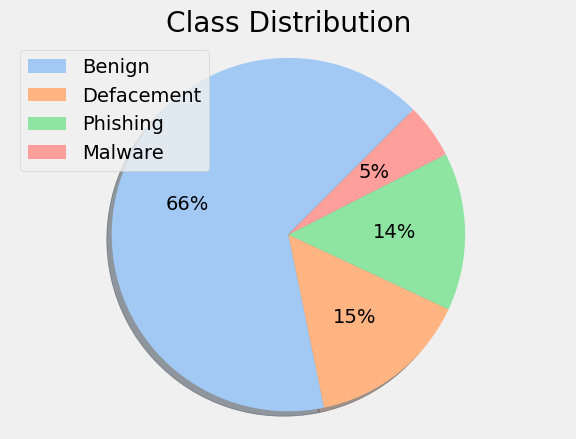

In [27]:
pie_chart(url_dataset, class_names)

## **5.2.   Polishing the Dataset**

In [28]:
def grind_dataset(dataset):

    # TODO: Balance dataset (instance selection or oversampling?)
    # TODO: Merge classes? ({defacement, phishing, malware} --> malicious

    url_dataset = url_length(dataset.copy())
    url_dataset['protocol'] = url_dataset['url'].apply(lambda x: url_protocol(x))
    url_dataset['digits_qtd'] = url_dataset['url'].apply(lambda x: count_digits(x))
    url_dataset['dirs_qtd'] = url_dataset['url'].apply(lambda x: count_dirs(x))
    url_dataset['fstdir_length'] = url_dataset['url'].apply(lambda x: first_directory(x))
    url_dataset['susp_words'] = url_dataset['url'].apply(lambda x: odd_words(x))

    # Equal frequency binning by url lengths
    categorical_size = ['Short', 'Normal', 'Long', 'Very Long']
    url_dataset['url_length'] = qcut(url_dataset['url_length'].copy(), q=4, labels=categorical_size)
    url_dataset = discretize_values(url_dataset.copy(), 'url_length')

    return url_dataset

In [30]:
polished_dataset = grind_dataset(url_dataset)

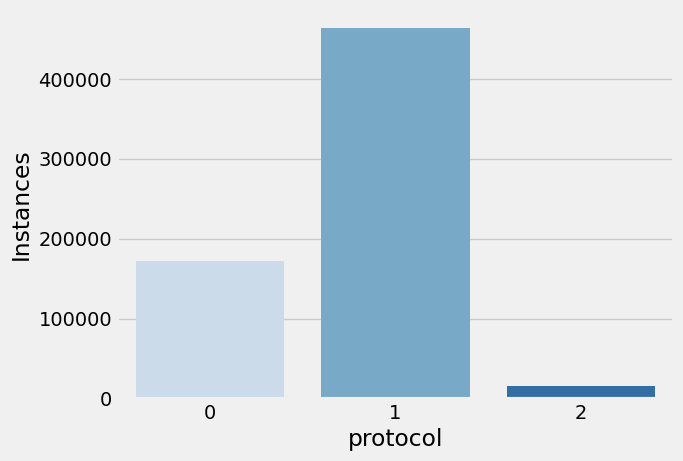

In [31]:
feature_dist(polished_dataset, 'protocol')

## **5.3.   Dataset Statistical Summary**

In [33]:
print(polished_dataset.isna().sum())

url              0
type             0
url_length       0
protocol         0
digits_qtd       0
dirs_qtd         0
fstdir_length    0
susp_words       0
dtype: int64


In [35]:
print(polished_dataset.describe().transpose())

                  count      mean        std  min  25%  50%  75%     max
url_length     651191.0  1.510136   1.115199  0.0  1.0  2.0  2.0     3.0
protocol       651191.0  0.759461   0.480456  0.0  0.0  1.0  1.0     2.0
digits_qtd     651191.0  5.527409  11.700814  0.0  0.0  2.0  7.0  1204.0
dirs_qtd       651191.0  2.317042   1.566924  0.0  1.0  2.0  3.0    39.0
fstdir_length  651191.0  8.843088  11.866214  0.0  4.0  6.0  9.0   408.0
susp_words     651191.0  0.028529   0.166479  0.0  0.0  0.0  0.0     1.0


In [36]:
print(polished_dataset.groupby('type').mean().loc['malware'])

url_length        1.328967
protocol          0.453198
digits_qtd       12.588346
dirs_qtd          2.078629
fstdir_length    14.190867
susp_words        0.003844
Name: malware, dtype: float64


## **5.4.   Normalization (Z-Score)**

In [40]:
attributes = polished_dataset.drop(['url', 'type'], axis='columns')
classes = discretize_values(polished_dataset.copy(), 'type')['type']

In [44]:
# Normalizes the attributes data (Z-Score)
attr_scaler = StandardScaler()
attributes = attr_scaler.fit_transform(attributes.copy())

## **5.5.   Logistic Regression**

              precision    recall  f1-score   support

      Benign       0.80      0.97      0.87     85621
  Defacement       0.68      0.90      0.78     19292
    Phishing       0.44      0.05      0.09      6504
     Malware       0.00      0.00      0.00     18822

    accuracy                           0.77    130239
   macro avg       0.48      0.48      0.43    130239
weighted avg       0.65      0.77      0.69    130239



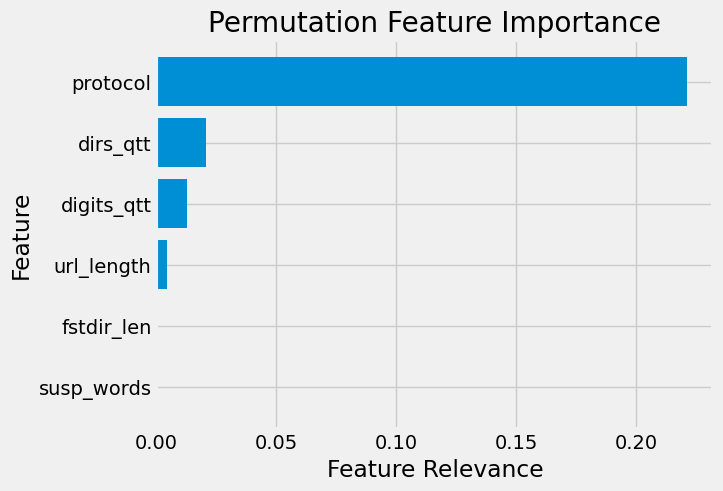

In [39]:
training_attributes, test_attributes, training_classes, test_classes = holdout_split(attributes, classes)
f_importances = logistic_regression(training_attributes, test_attributes,
                                    training_classes, test_classes, class_names)
calculate_importances(f_importances, feature_names)

## **5.6.   XGBoost**

In [41]:
training_attributes, test_attributes, training_classes, test_classes = holdout_split(attributes, classes)
f_importances = xgb_classification(training_attributes, test_attributes,
                                    training_classes, test_classes, class_names).tolist()

              precision    recall  f1-score   support

      Benign       0.90      0.98      0.94     85621
  Defacement       0.91      0.95      0.93     19292
    Phishing       0.94      0.84      0.89      6504
     Malware       0.85      0.51      0.64     18822

    accuracy                           0.90    130239
   macro avg       0.90      0.82      0.85    130239
weighted avg       0.90      0.90      0.89    130239



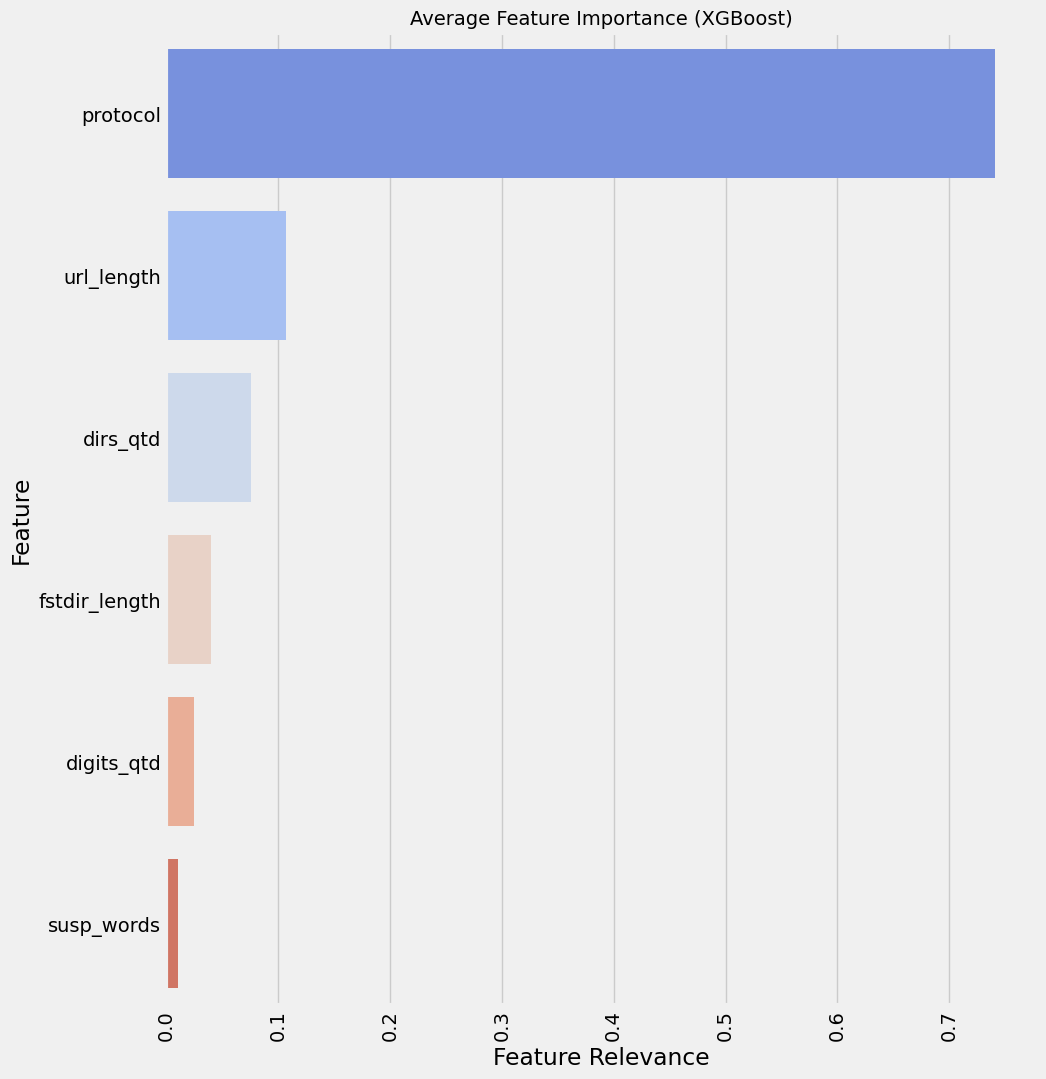

In [42]:
cols = training_attributes.columns
feature_dataframe = DataFrame({'Features': cols, 'XGBoost Feature Importances': f_importances})
feature_dataframe['Mean'] = feature_dataframe.mean(axis=1)
plot_feature_importance(test_attributes.columns, feature_dataframe)

## **5.7.   Cross-Validation**

In [46]:
classifier = xgb.XGBClassifier(base_score=0.5,
                               booster='gbtree',
                               n_estimators=200,
                               n_jobs=-1,
                               objective='reg:squarederror',
                               max_depth=5,
                               learning_rate=0.1)
cv_learning(attributes, classes, classifier)

F1 Score Mean: 0.8218246353658317
F1 Score StD:  0.001907892449405127


In [45]:
classifier = LogisticRegression(n_jobs=-1)
cv_learning(attributes, classes, classifier)

F1 Score Mean: 0.4343240025832924
F1 Score StD:  0.0014418608790156475
